<a id="libraries"></a>
# <b><span style='color:#ff6200'> Swiss and Roll Analysis</span></b>

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 500, noise = 0.25, random_state = 42)
df = pd.DataFrame(X, columns = ['x1','x2'])
df['y'] = y

<a id="libraries"></a>
# <b><span style='color:#ff6200'> Informations </span></b>

In [23]:
df.head()

,x1,x2,y
0,0.830948,-0.296546,1
1,1.088387,0.899693,0
2,1.135634,-0.462935,1
3,-0.082277,1.059718,0
4,0.443047,1.418977,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      500 non-null    float64
 1   x2      500 non-null    float64
 2   y       500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [25]:
df.describe()

,x1,x2,y
count,500.000000,500.000000,500.000000
mean,0.522681,0.256708,0.500000
std,0.910056,0.567666,0.500501
min,-1.608490,-1.117437,0.000000
25%,-0.096352,-0.193848,0.000000
50%,0.475017,0.281267,0.500000
75%,1.160498,0.706677,1.000000
max,2.641900,1.635114,1.000000


In [26]:
df.isna().sum()

x1    0
x2    0
y     0
dtype: int64

In [32]:
df.y.unique()

array([1, 0])

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Plots </span></b>

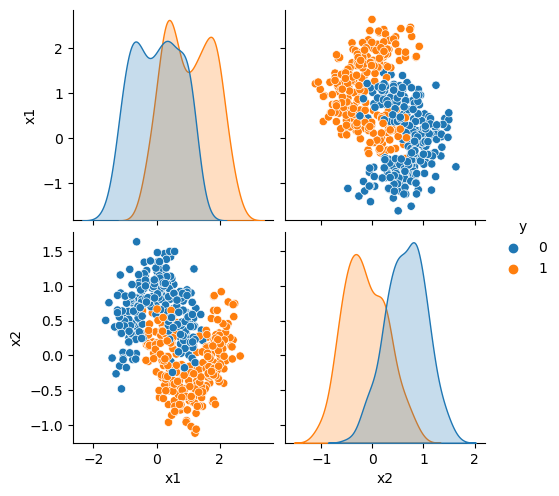

In [33]:
sns.pairplot(df,hue ='y')
plt.show()

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Correlation </span></b>

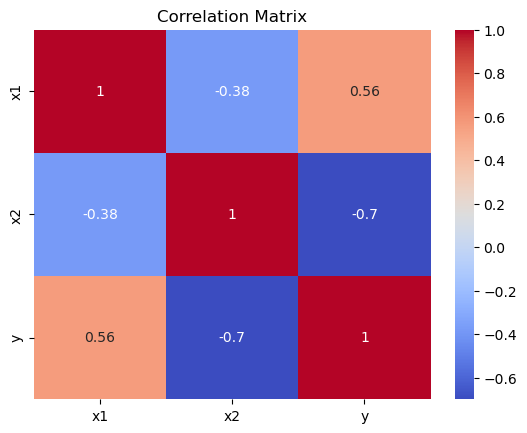

In [35]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix,annot=True,cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Split </span></b>

In [36]:
from sklearn.model_selection import train_test_split

X,y = df[['x1','x2']],df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Model Selection </span></b>

## Preprocessing 

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'